# Convolution Neural Network (CNN)

[![image.png](https://i.postimg.cc/mrXbbMF6/image.png)](https://postimg.cc/t160kskh)

<br>

```text
Layers In A CNN
---------------
- Convolution: This layer learns the filter/kernel used to create feature maps.
- Poooling: This layer is used to reduce the spatial dimension of the image and increase the receptive field size.
- Fully connected: AKA ANN/FFN. It's used for making predictions.

Typical Architecture
--------------------
Conv -> Pool -> FFN
```

## Implementations

1. [Medium blog](https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48)
2. [Notebook 1](https://colab.research.google.com/drive/1UD2RIXreLLgUDfLauJqR41QrLw3ufwbN#scrollTo=gHzKOZjnp0qn)

In [1]:
# Built-in library
import logging
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import numpy.typing as npt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as T
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Configure the backend
import matplotlib_inline.backend_inline

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 2_000

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
import seaborn as sns

# Custom import
from src.utilities import (
    set_up_logger,
    create_iris_data,
    create_qwerties_data,
    smooth,
)
from src.data_manager import (
    load_data,
    create_data_loader,
    split_into_train_n_validation,
)
from src.preprocessor import Standardizer, Normalizer


# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

### Load/Download MNIST Digits Data

In [2]:
fp = "../../data/mnist_digit"

# Chain multiple transformations
transform = T.Compose(
    [
        # Convert to PyTorch tensors
        T.ToTensor(),
        #  It performs per-channel normalization, where each channel
        # (e.g., red, green, blue for an RGB image) is normalized independently.
        # Since it's a single channel, we have (0.5,)
        T.Normalize(mean=(0.5,), std=(0.5,)),
    ]
)

train_dataset = MNIST(root=fp, train=True, transform=transform, download=True)
test_dataset = MNIST(root=fp, train=False, transform=transform, download=True)

## Steps For Calculating The Output of The Layer 

### Formula For The Size of Image At The Current Layer

$$ N = \lfloor{(\frac{M + 2p - k}{S})}\rfloor + 1$$

```text
N = Number of pixels in the current layer.
M = Number of pixels in the previous layer.
2p = Padding (it's multiplied by 2 because it's symmetric)
K = Number of pixels in the kernel/filter.
S = Stride parameter
⌊⌋ = floor (i.e 2.2 becomes 2.0)
```
<br>

```python
class CNNModel(nn.Module):
    def __init__(self, display_shape: bool = False) -> None:
        super().__init__()
        self.display_shape = display_shape
        # Conv layer
        self.conv_1 = nn.Conv2d(
            in_channels=1, out_channels=10, kernel_size=5, stride=1, padding=1
        )
        # Size of the output of the conv layer (equation is shown above)
        # Step 1
        # NB: 28 (this is the size of the image. i.e 28X28)
        # size_1 = np.floor((28 + (2*1) - 5) / 1 ) + 1 = 26/2 = 13 (/2 cox of maxpool)

        self.conv_2 = nn.Conv2d(
            in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=1
        )
        # Step 2
        # NB: 13 (this is the output of conv_1. i.e size_1)
        # size_2 = np.floor((13 + (2 * 1) - 5) / 1) + 1 = 11/2 = 5 (/2 cox of maxpool)

        # ========== Fully Connected Layer ==========
        # Compute the number of units in the FCLayer (i.e. output of conv_2)
        # NB: This FCLayer has no padding or stride
        expected_size = 5 # (size_2)
        # Find the square since it's symmetrical
        expected_size = 20 * int(np.square(expected_size))
        self.fc_layer_3 = nn.Linear(expected_size, 50)

        # ========== Output Layer ==========
        self.output = nn.Linear(50, 10)

```

#### Steps

```text
Step 1: Calculate the output of conv_1
    - size_1 = np.floor((28 + (2*1) - 5) / 1 ) + 1 = 26/2 = 13 (/2 cox of maxpool)

Step 2: Calculate the output of conv_2
    - size_2 = np.floor((13 + (2 * 1) - 5) / 1) + 1 = 11/2 = 5 (/2 cox of maxpool)

Step 3: Calculate the input of the fully connected layer
    - input_size = size_2 * size_2
      self.fc_layer_3 = nn.Linear(input_size x n_channels, 50)

```

<br><hr>



In [3]:
def _calculate_size(
    image_input: int, padding: int, kernel_size: int, stride: int
) -> int:
    """This is used to calculate the output of the CNN."""
    output = np.floor(((image_input + 2 * padding - kernel_size) / stride)) + 1
    return np.floor(output / 2)


def calculate_layer_input(
    image_input: int, padding: int, kernel_size: int, stride: int
) -> int:
    """This is used to calculate the input of the fully connected layer in a CNN."""
    step_1 = _calculate_size(
        image_input=image_input, padding=padding, kernel_size=kernel_size, stride=stride
    )
    step_2 = _calculate_size(
        image_input=step_1, padding=padding, kernel_size=kernel_size, stride=stride
    )
    output = int(step_2)
    return output

### Configurations

In [4]:
# Set random seeds for reproducibility
RANDOM_STATE = 123

torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

In [5]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# If we're on a CUDA machine, this should print a CUDA device:
print(f"Working on device={device}")

Working on device=cpu


### Hyper-parameters


In [6]:
# Each MNSIT image is 1x28x28, so it is an 2D array [28,28]
# I'll flatten the image as vector dim=1*28*28
input_size = 1 * 28 * 28
hidden_size = 128
num_classes = 10
num_epochs = 5
batch_size = 64
learning_rate = 0.001

train_size = int(0.8 * len(train_dataset))  # 80% of training data
val_size = len(train_dataset) - train_size  # 20% of training data

### Prepare The Data

In [7]:
# Split the training dataset into training and validation sets
train_dataset, val_dataset = random_split(
    dataset=train_dataset,
    lengths=[train_size, val_size],
)

# Create DataLoader for each dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Define CNN

In [8]:
class CNN(nn.Module):
    """This is used to build a Convolutional Neutral Network architecture that
    is used for classification.

    Params:
        input_size: This is the output of the final conv layer.
        num_classes (int): This is the number of class labels in the input data.
    """

    def __init__(self, input_size: int, num_classes: int) -> None:
        super().__init__()
        self.conv_1 = nn.Conv2d(
            in_channels=1, out_channels=10, kernel_size=5, stride=1, padding=1
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_2 = nn.Conv2d(
            in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=1
        )
        self.fc1 = nn.Linear((20 * input_size * input_size), 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """This performs the forward propagation."""

        # Conv -> pool
        x = self.pool(F.relu(self.conv_1(x)))
        x = self.pool(F.relu(self.conv_2(x)))

        # Flatten the input images to have the dim:
        # (num_samples, n_channels, n_input, n_input)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [9]:
# Test the model with random data
# (1_000, 1, 28, 28): (n_samples, n_channels, image_size, image_size)
conv_output_size = calculate_layer_input(
    image_input=28, padding=1, kernel_size=5, stride=1
)
print(f"Output of Conv Layer: {conv_output_size}\n")
cnn_model = CNN(input_size=conv_output_size, num_classes=num_classes)
X_ = torch.rand(size=(1_000, 1, 28, 28))

result = cnn_model.forward(x=X_)
result.shape

Output of Conv Layer: 5



torch.Size([1000, 10])

### Train Model

In [10]:
# ==== Init model ====
model = CNN(input_size=conv_output_size, num_classes=num_classes).to(device=device)

# ==== Define loss function and optimizer ====
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# ==== Training loop ====
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0

    # ==== Batch training loop ====
    for images, labels in train_loader:
        # Push the data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # ==== Forwardprop ====
        outputs = model(images)
        loss: nn.CrossEntropyLoss = criterion(outputs, labels)

        # ==== Backprop ====
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update the loss
        running_loss += loss.item()

    # ==== Validation loop ====
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            # Push the data to GPU if available
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels).item()
            # It returns the value and the index.
            # We're interested in the index
            _, predicted = torch.max(outputs, dim=1)
            val_total += labels.size(0)  # or labels.shape[0]
            val_correct += (predicted == labels).sum().item()
    val_accuracy = (val_correct / val_total) * 100

    print(
        f"Epoch {epoch + 1}/{num_epochs}, "
        f"Training Loss: {running_loss / len(train_loader)}, "
        f"Validation Loss: {val_loss / len(val_loader)}, "
        f"Validation Accuracy: {val_accuracy:.2f}%"
    )

# Test the model on the test dataset
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        # Push the data to GPU if available
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        # It returns the value and the index.
        # We're interested in the index
        predicted = torch.argmax(outputs, dim=1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = (test_correct / test_total) * 100
print(f"Test Accuracy: { test_accuracy:.2f}%")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5, Training Loss: 0.25127373782421153, Validation Loss: 3.800730894696205e-05, Validation Accuracy: 97.51%
Epoch 2/5, Training Loss: 0.07121194873315592, Validation Loss: 8.850435211144863e-06, Validation Accuracy: 98.24%
Epoch 3/5, Training Loss: 0.0531672629302678, Validation Loss: 1.5563384798216694e-05, Validation Accuracy: 97.87%
Epoch 4/5, Training Loss: 0.0442768574632549, Validation Loss: 5.358813994346147e-06, Validation Accuracy: 98.78%
Epoch 5/5, Training Loss: 0.03791645892313682, Validation Loss: 0.00021415776474044678, Validation Accuracy: 98.68%
Test Accuracy: 98.62%


## Putting It All Together

In [11]:
class CNN(nn.Module):
    """This is used to build a Convolutional Neutral Network architecture that
    is used for classification.

    Params:
        input_size: This is the output of the final conv layer.
        num_classes (int): This is the number of class labels in the input data.
    """

    def __init__(self, input_size: int, num_classes: int) -> None:
        super().__init__()
        self.conv_1 = nn.Conv2d(
            in_channels=1, out_channels=10, kernel_size=5, stride=1, padding=1
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_2 = nn.Conv2d(
            in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=1
        )
        self.fc1 = nn.Linear((20 * input_size * input_size), 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """This performs the forward propagation."""

        # Conv -> pool
        x = self.pool(F.relu(self.conv_1(x)))
        x = self.pool(F.relu(self.conv_2(x)))

        # Flatten the input images to have the dim:
        # (num_samples, n_channels, n_input, n_input)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [12]:
def train(
    model: CNN,
    device: Any,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: Any,
    optimizer: torch.optim,
    num_epochs: int,
) -> CNN:
    """This is used for training the model."""
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0

        # ==== Batch training loop ====
        for images, labels in train_loader:
            # Push the data to GPU if available
            images, labels = images.to(device), labels.to(device)

            # ==== Forwardprop ====
            outputs = model(images)
            loss: nn.CrossEntropyLoss = criterion(outputs, labels)

            # ==== Backprop ====
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Update the loss
            running_loss += loss.item()

        # ==== Validation loop ====
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                # Push the data to GPU if available
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss = criterion(outputs, labels).item()
                # It returns the value and the index.
                # We're interested in the index
                _, predicted = torch.max(outputs, dim=1)
                val_total += labels.size(0)  # or labels.shape[0]
                val_correct += (predicted == labels).sum().item()
        val_accuracy = (val_correct / val_total) * 100

        print(
            f"Epoch {epoch + 1}/{num_epochs}, "
            f"Training Loss: {running_loss / len(train_loader)}, "
            f"Validation Loss: {val_loss / len(val_loader)}, "
            f"Validation Accuracy: {val_accuracy:.2f}%"
        )
    return model


def test(model: CNN, device: Any, test_loader: DataLoader):
    """This is used to the model on the test dataset."""
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # Push the data to GPU if available
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = (test_correct / test_total) * 100
    print(f"Test Accuracy: {test_accuracy:.2f}%")

In [13]:
conv_output_size = calculate_layer_input(
    image_input=28, padding=1, kernel_size=5, stride=1
)
print(f"Output of Conv Layer: {conv_output_size}\n")

Output of Conv Layer: 5



In [14]:
### Hyper-parameters

# Each MNSIT image is 1x28x28, so it is an 2D array [28,28]
# I'll flatten the image as vector dim=1*28*28
input_size = 1 * 28 * 28
hidden_size = 128
num_classes = 10
num_epochs = 10
batch_size = 64
learning_rate = 0.001

train_size = int(0.8 * len(train_dataset))  # 80% of training data
val_size = len(train_dataset) - train_size  # 20% of training data

In [15]:
# Create DataLoader for each dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [16]:
def main():
    """This is the main function."""
    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # If we're on a CUDA machine, this should print a CUDA device:
    print(f"Working on device={device!r}")

    # ==== Init model ====
    model = CNN(
        input_size=conv_output_size,
        num_classes=num_classes,
    ).to(device=device)

    # ==== Define loss function and optimizer ====
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    # ==== Train the model ====
    model = train(
        model,
        device=device,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=num_epochs,
    )

    # ==== Evaluate the model ====
    test(model, device=device, test_loader=test_loader)

In [17]:
# Train and evaluate
main()

Working on device=device(type='cpu')


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Training Loss: 0.2273889376167208, Validation Loss: 3.098180032077622e-05, Validation Accuracy: 97.37%
Epoch 2/10, Training Loss: 0.0652927413303405, Validation Loss: 1.767780904242016e-05, Validation Accuracy: 98.43%
Epoch 3/10, Training Loss: 0.04843874897264565, Validation Loss: 8.854387759013062e-06, Validation Accuracy: 98.60%
Epoch 4/10, Training Loss: 0.03742078764953961, Validation Loss: 2.32238783203858e-06, Validation Accuracy: 98.78%
Epoch 5/10, Training Loss: 0.03157742127877039, Validation Loss: 4.4605394384447245e-06, Validation Accuracy: 98.22%
Epoch 6/10, Training Loss: 0.027330242471963476, Validation Loss: 1.5304561337812785e-05, Validation Accuracy: 98.72%
Epoch 7/10, Training Loss: 0.023259358406668373, Validation Loss: 4.8079503145306665e-06, Validation Accuracy: 98.82%
Epoch 8/10, Training Loss: 0.01969358376225864, Validation Loss: 1.160077691236709e-05, Validation Accuracy: 98.62%
Epoch 9/10, Training Loss: 0.01851881228754064, Validation Loss: 1.038

## CIFAR10 Data

<br>

### Load CIFAR10 Data

In [18]:
cifar10_fp = "../../data/cifar10/"

transform = T.Compose(
    [
        # Convert to PyTorch tensors
        T.ToTensor(),
        T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
)
train_dataset = CIFAR10(root=cifar10_fp, train=True, transform=transform, download=True)
test_dataset = CIFAR10(root=cifar10_fp, train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
# Dimension of the data
train_dataset.data.shape, test_dataset.data.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [20]:
train_dataset.data[:2]

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [21]:
train_dataset.targets[:20], train_dataset.classes

([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6],
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

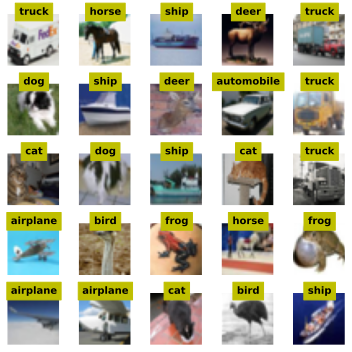

In [22]:
# Visualize some samples from the data.
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(5, 5))

for ax in axs.flatten():
    # Select random image
    rand_idx = np.random.choice(len(train_dataset.targets))

    # Extract that image
    pic = train_dataset.data[rand_idx, :, :, :]

    # Extract the label
    label = train_dataset.classes[train_dataset.targets[rand_idx]]

    # Visualize the image
    ax.imshow(pic)

    # Annotate the image
    ax.text(
        x=16,
        y=0,
        s=label,
        ha="center",
        fontweight="bold",
        color="k",
        backgroundcolor="y",
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

In [23]:
class CNN2(nn.Module):
    """This is used to classify the CIFAR10 data.

    Args:
        input_size (int): This is the output of the final conv layer.
        num_classes (int): This is the number of class labels in the input data.
    """

    def __init__(self, input_size: int, num_classes: int) -> None:
        super().__init__()
        self.conv_1 = nn.Conv2d(
            in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2
        )
        self.fc_1 = nn.Linear(
            in_features=(32 * input_size * input_size), out_features=50
        )
        self.fc_2 = nn.Linear(in_features=50, out_features=num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """This is used to perform forward propagation."""
        # Conv -> pool
        x = F.relu(self.conv_1(x))
        x = self.pool(x)
        # Conv -> pool
        x = F.relu(self.conv_2(x))
        x = self.pool(x)
        # Flatten the images: (n_samples, n_channels, n_input, n_input)
        x = x.view(x.size(0), -1)
        x = self.fc_1(x)
        x = self.fc_2(x)
        return x

In [24]:
# Test the model with random data
# (1_000, 3, 32, 32): (n_samples, n_channels, image_size, image_size)
conv_output_size = calculate_layer_input(
    image_input=32, padding=2, kernel_size=5, stride=1
)
print(f"Output of Conv Layer: {conv_output_size}\n")
cnn_model = CNN2(input_size=conv_output_size, num_classes=num_classes)
X_ = torch.rand(size=(1_000, 3, 32, 32))

result = cnn_model.forward(x=X_)
result.shape

Output of Conv Layer: 8



torch.Size([1000, 10])

In [25]:
train_size = int(0.8 * len(train_dataset))  # 80% of training data
val_size = len(train_dataset) - train_size  # 20% of training data

# Split the training dataset into training and validation sets
train_dataset, val_dataset = random_split(
    dataset=train_dataset,
    lengths=[train_size, val_size],
)

# Create DataLoader for each dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Improve The Model

- Improve the model architecture

In [26]:
class CNN2(nn.Module):
    """This is used to classify the CIFAR10 data.

    Args:
        input_size (int): This is the output of the final conv layer.
        num_classes (int): This is the number of class labels in the input data.
    """

    def __init__(self, input_size: int, num_classes: int) -> None:
        super().__init__()
        self.conv_1 = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=2
        )
        self.batch_norm_1 = nn.BatchNorm2d(num_features=64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_2 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2
        )
        self.batch_norm_2 = nn.BatchNorm2d(num_features=128)
        self.fc_1 = nn.Linear(
            in_features=(128 * input_size * input_size), out_features=32
        )
        self.fc_2 = nn.Linear(in_features=32, out_features=num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """This is used to perform forward propagation."""
        # Conv -> pool
        x = self.batch_norm_1(self.pool(self.conv_1(x)))
        x = F.leaky_relu(x)
        # Conv -> pool
        x = self.batch_norm_2(self.pool(self.conv_2(x)))
        x = F.leaky_relu(x)
        # Flatten the images: (n_samples, n_channels, n_input, n_input)
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc_1(x))
        x = F.dropout(input=x, p=0.2, training=self.training)
        x = self.fc_2(x)
        return x

In [27]:
def train(
    model: CNN2,
    device: Any,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: Any,
    optimizer: torch.optim,
    num_epochs: int,
) -> CNN2:
    """This is used for training the model."""
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0

        # ==== Batch training loop ====
        for images, labels in train_loader:
            # Push the data to GPU if available
            images, labels = images.to(device), labels.to(device)

            # ==== Forwardprop ====
            outputs = model(images)
            loss: nn.CrossEntropyLoss = criterion(outputs, labels)

            # ==== Backprop ====
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Update the loss
            running_loss += loss.item()

        # ==== Validation loop ====
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                # Push the data to GPU if available
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss = criterion(outputs, labels).item()
                # It returns the value and the index.
                # We're interested in the index
                _, predicted = torch.max(outputs, dim=1)
                val_total += labels.size(0)  # or labels.shape[0]
                val_correct += (predicted == labels).sum().item()
        val_accuracy = (val_correct / val_total) * 100

        print(
            f"Epoch {epoch + 1}/{num_epochs}, "
            f"Training Loss: {running_loss / len(train_loader)}, "
            f"Validation Loss: {val_loss / len(val_loader)}, "
            f"Validation Accuracy: {val_accuracy:.2f}%"
        )
    return model


def test(model: CNN2, device: Any, test_loader: DataLoader):
    """This is used to the model on the test dataset."""
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # Push the data to GPU if available
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = (test_correct / test_total) * 100
    print(f"Test Accuracy: {test_accuracy:.2f}%")

In [28]:
# Each MNSIT image is 3x32x32, so it is an 2D array [32,32]
# I'll flatten the image as vector dim=3*32*32
input_size = 3 * 32 * 32
num_classes = 10
num_epochs = 5
batch_size = 64
learning_rate = 0.001

In [29]:
train_size = int(0.8 * len(train_dataset))  # 80% of training data
val_size = len(train_dataset) - train_size  # 20% of training data

# Split the training dataset into training and validation sets
train_dataset, val_dataset = random_split(
    dataset=train_dataset,
    lengths=[train_size, val_size],
)

# Create DataLoader for each dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [30]:
def main():
    """This is the main function."""
    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # If we're on a CUDA machine, this should print a CUDA device:
    print(f"Working on device={device!r}")

    # ==== Init model ====
    model = CNN2(
        input_size=conv_output_size,
        num_classes=num_classes,
    ).to(device=device)

    # ==== Define loss function and optimizer ====
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    # ==== Train the model ====
    model = train(
        model,
        device=device,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=num_epochs,
    )

    # ==== Evaluate the model ====
    test(model, device=device, test_loader=test_loader)
    return model

In [31]:
model = main()

Working on device=device(type='cpu')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5, Training Loss: 1.5886487672328948, Validation Loss: 0.00832212257385254, Validation Accuracy: 56.86%
Epoch 2/5, Training Loss: 1.2138703325986862, Validation Loss: 0.006976844787597657, Validation Accuracy: 61.12%
Epoch 3/5, Training Loss: 1.0577283363342285, Validation Loss: 0.0056973214149475095, Validation Accuracy: 66.09%
Epoch 4/5, Training Loss: 0.9550889675617218, Validation Loss: 0.004495741367340088, Validation Accuracy: 68.54%
Epoch 5/5, Training Loss: 0.8574697574973107, Validation Loss: 0.00412692642211914, Validation Accuracy: 71.05%
Test Accuracy: 71.76%


In [32]:
# Make predictions with the model
X, y = next(iter(test_loader))
x_, y_ = X[0:1], y[0:1]
y_pred = torch.argmax(model(x_), dim=1)
y_pred_label = test_dataset.classes[y_pred]
y_pred_true = test_dataset.classes[y_]

print(f"Actual: {y_pred_true}, \nPredicted: {y_pred_label}")

Actual: cat, 
Predicted: cat
